In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pylab as plt
import sys

from kfsims.common import init_trajectory, init_all

In [3]:
def predict_state(F_l, x_l__l):
    """
    Step 1
    """
    return F_l @ x_l__l


def predict_PECM(F_l, P_l__l, Q_l):
    """
    Step 2
    """
    return F_l @ P_l__l @ F_l.T + Q_l

def init(P_k__l, tau, n, rho, u_l__l, m, U_l__l):
    """
    Step 3.
    """
    t_k__l = n + tau + 1
    T_k__l = tau * P_k__l
    u_k__l = rho * (u_l__l - m - 1) + m + 1
    U_k__l = rho * U_l__l
    return t_k__l, T_k__l, u_k__l, U_k__l


In [4]:
traj, xk, P, tau, rho, u, U, H, F, Q, N = init_all()

In [5]:
pl = traj.Y.T + np.random.normal(size=traj.Y.shape).T * 10

In [32]:
n = P.shape[0]
m = Q.shape[0]
x_log = []
P_log = []
for zk in pl:
#    print('===== Step: ', t, '======') 
    #t += 1
    
    #### Time update
    xk = predict_state(F, xk)
    P = predict_PECM(F, P, Q)
    
    #### Measurement update
    # Initialization - step 3
    tkk, Tkk, ukk, Ukk = init(P, tau, n, rho, u, m, U)
    
    ## VB iters
    Pik = P
    xikk = xk
    for i in range(N):
        # steps 4, 5
        err = np.atleast_2d(xikk - xk)
        Aik = Pik + np.outer(err, err)
        tik = tkk + 1
        Tik = Aik + Tkk
        
        # steps 6, 7
        err = np.atleast_2d(zk - H.dot(xikk))
        Bik = err.T.dot(err) + H.dot(Pik).dot(H.T)
        uik = ukk + 1
        Uik = Bik + Ukk
        
        # steps 8
        ERkinv = (uik - m - 1) * np.linalg.inv(Uik)
        EPkinv = (tik - n - 1) * np.linalg.inv(Tik)
        
        # steps 9
        Pik = np.linalg.inv(EPkinv)
        Rik = np.linalg.inv(ERkinv)
        
        # steps 10-12
        bracket = H.dot(Pik).dot(H.T) + Rik
        Kik = Pik.dot(H.T).dot(np.linalg.inv(bracket))
        xikk = xk + Kik.dot(zk - H.dot(xk))
        Pik = Pik - Kik.dot(H).dot(Pik)
    
    xk = xikk
    P = Pik
    Tkk = Tik
    ukk = uik
    Ukk = Uik
    
    x_log.append(xk)
    P_log.append(P)

x_log = np.array(x_log).squeeze().T
P_log = np.array(P_log).squeeze()

print(np.mean(np.sqrt(((x_log[:, 10:] - traj.X[:, 10:])**2).mean(axis=1))))

#plt.figure(figsize=(10, 10))
#plt.axis('equal')
#plt.plot(traj.X[0], traj.X[1], label='True states')
#plt.plot(traj.Y[0], traj.Y[1], 'r+', label='Measurements')
#plt.plot(x_log[0], x_log[1], 'k+', label='Estimates from KF')
#plt.legend()
#
#plt.figure(figsize=(10, 4))
#plt.subplot(121)
#plt.plot(traj.X[2], label='velocity x')
#plt.plot(x_log[2], label='KF estimate')
#plt.legend()
#plt.subplot(122)
#plt.plot(traj.X[3], label='velocity y')
#plt.plot(x_log[3], label='KF estimate')
#plt.legend()


3.1489737413910808


# POZNATEK VOLE! Na začátku Kalmana, než se to chytí, mám v odhadu rychlostí (3 a 4 složka) hrozně velký peak než se to chytne, asi 10-20 iterace. To ovlivňuje RMSE a dost pravděpodobně na to má vliv počet iterací - jako kdyby to víc iterací dotlačilo v tom počátku do extrému a to mi právě rozhazuje to RMSE. V případě více nodeů to bude stejné - bude se mi to tam více nasčítávat. 

* RMSE není spásné pro všechno
* možná hodnotit jen odhady těch lokací
* všechny 3 implementace se chovají stejně

In [42]:
from kfsims import common
from kfsims.node import node_factory, observe_factory

In [43]:
iterations = 20
traj2, xk, P, tau, rho, u, U, H, F, Q, N = common.init_all()
traj2.Y = traj2.Y + (np.random.normal(size=traj2.Y.shape)) * 10
nd = node_factory(xk, P, u, U, F, Q, H, rho, tau, observe_factory(traj2.Y.T.copy()), iterations)
nd()
np.mean(nd.post_rmse(traj.X))

2.8955398810657007

In [12]:
%matplotlib notebook

In [13]:
kfc = np.load('/home/dan/tst.np.npy')

<IPython.core.display.Javascript object>


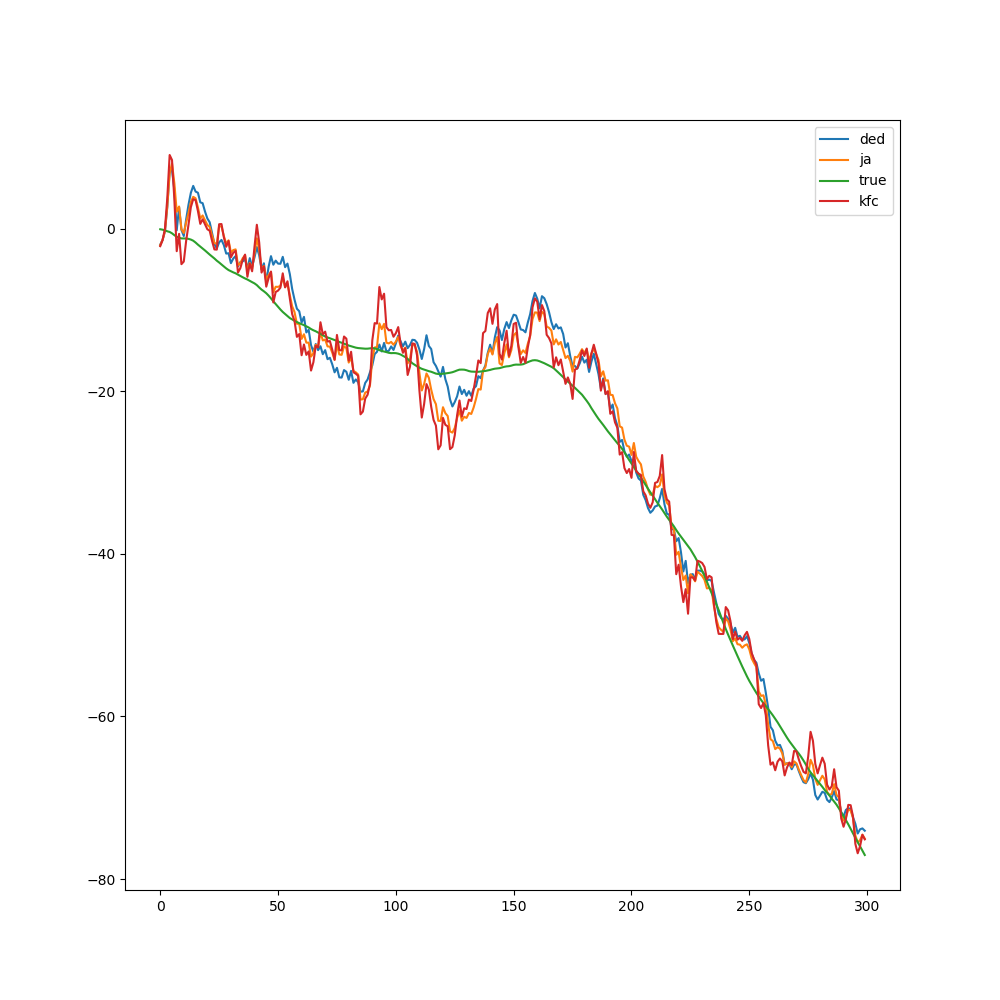

In [14]:
sl = 1
plt.figure(figsize=(10,10))
plt.plot(x_log[sl, :], label='ded')
plt.plot(np.array(nd.logger['x'])[:, sl], label='ja')
plt.plot(np.array(traj.X.T[:, sl]), label='true')
plt.plot(kfc[:, sl, 0], label='kfc')
plt.legend()

<IPython.core.display.Javascript object>


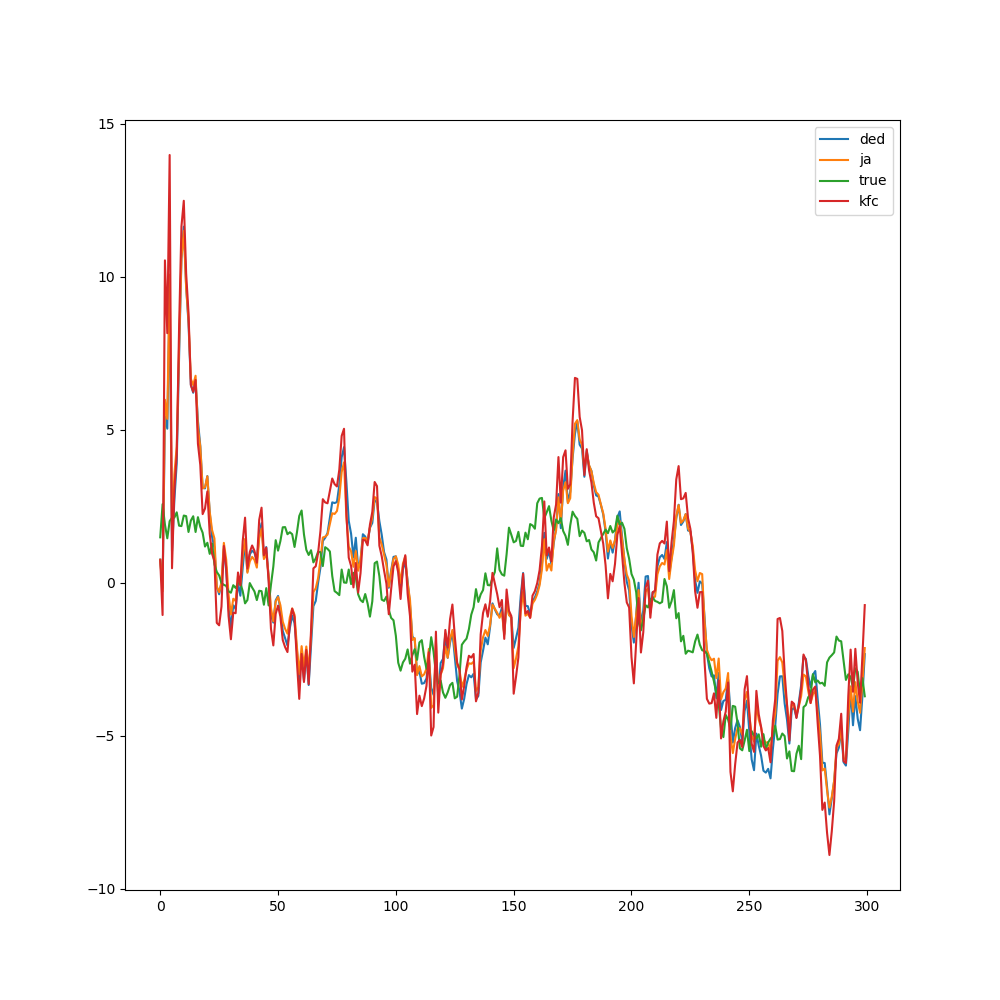

In [48]:
sl = 2
plt.figure(figsize=(10,10))
plt.plot(x_log[sl, :], label='ded')
plt.plot(np.array(nd.logger['x'])[:, sl], label='ja')
plt.plot(np.array(traj.X.T[:, sl]), label='true')
plt.plot(kfc[:, sl, 0], label='kfc')
plt.legend()

<IPython.core.display.Javascript object>


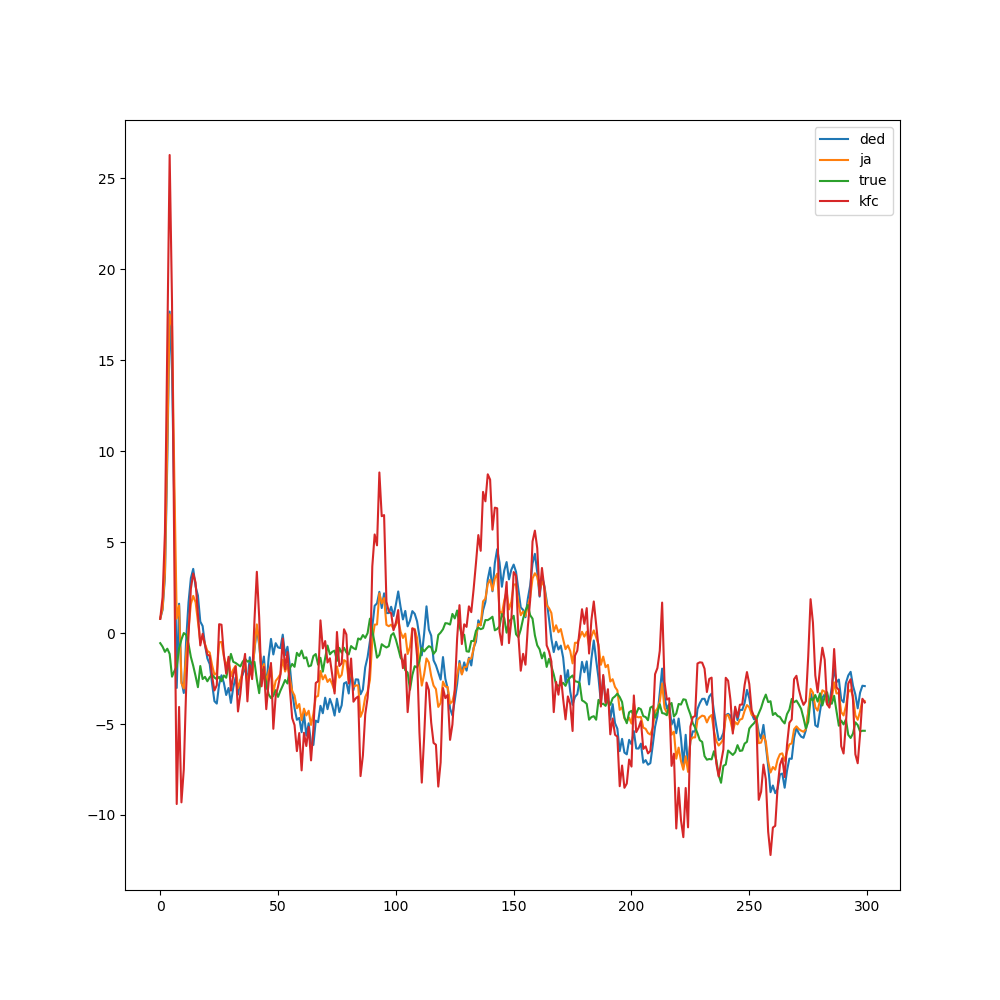

In [15]:
sl = 3
plt.figure(figsize=(10,10))
plt.plot(x_log[sl, :], label='ded')
plt.plot(np.array(nd.logger['x'])[:, sl], label='ja')
plt.plot(np.array(traj.X.T[:, sl]), label='true')
plt.plot(kfc[:, sl, 0], label='kfc')
plt.legend()

<IPython.core.display.Javascript object>


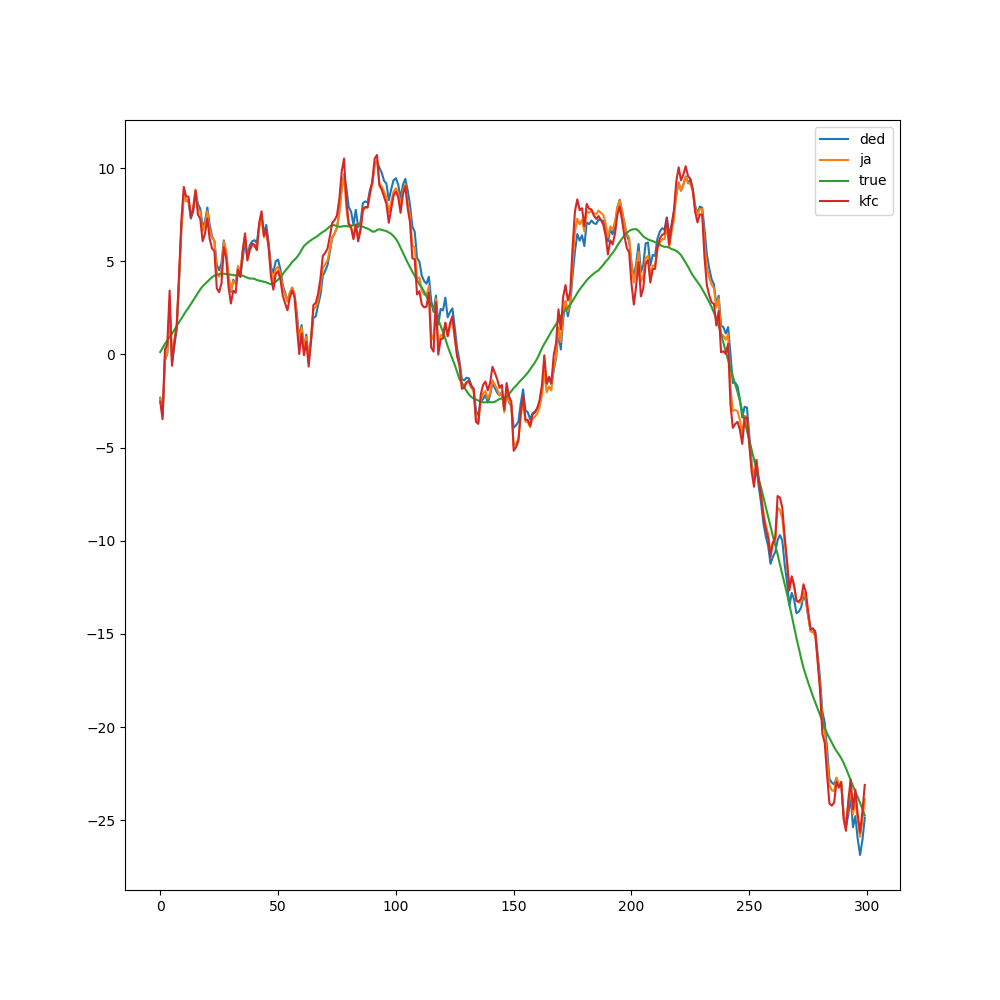

In [52]:
sl = 0
plt.figure(figsize=(10,10))
plt.plot(x_log[sl, :], label='ded')
plt.plot(np.array(nd.logger['x'])[:, sl], label='ja')
plt.plot(np.array(traj.X.T[:, sl]), label='true')
plt.plot(kfc[:, sl, 0], label='kfc')
plt.legend()